# Adding Inset Maps to a Matplotlib Plot
[Inset maps](https://en.wikipedia.org/wiki/Map_layout#Inset_map) are elements commonly added to maps to show additional detail of a smaller region, show the location of the map within a larger region, or to show another region that is discontiguous from the main portion of the map.

Two options exist for easily adding these elements to the default `matplotlib` plots generated by GeoPandas' `plot()` function: either the functions included in the base `matplotlib` library, or the `matplotlib-map-utils` library (see [here](https://github.com/moss-xyz/matplotlib-map-utils)). The use of each is described below.

## Using `matplotlib`
Two distinct functions within `matplotlib` provide the functionality to add inset axes to already-existing axes. Confusingly, both are named `inset_axes()`, but one lives within `matplotlib`, and the other within `mpl_toolkits.axes_grid1`.

### Using `matplotlib.axes.Axes.inset_axes()`

The first option is to use the [inset_axes](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.inset_axes.html) method available in matplotlib.

In [1]:
import geopandas as gpd
from geodatasets import get_path

#### Creating the Parent Axis
The "parent axis" is the one that will contain the inset axes (also called a "child axis"). This is the axis that is returned by the `plot()` function.

<class 'matplotlib.axes._axes.Axes'>


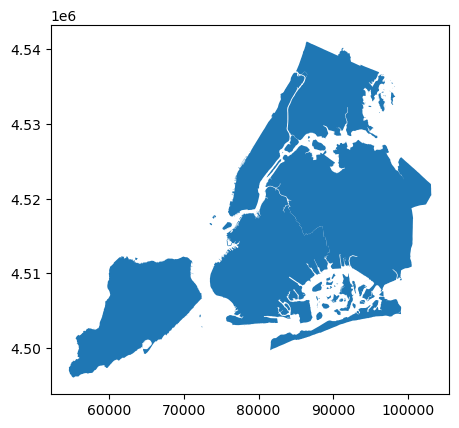

In [2]:
nybb = gpd.read_file(get_path("nybb"))
nybb = nybb.to_crs(epsg=32619)  # Convert the dataset to a coordinate system which uses meters

ax = nybb.plot()
print(type(ax))

#### Adding an Inset Axis
The inset axis (or "child axis", relative to the "parent axis" created by `.plot()`) can be added via the `inset_axes()` method on an `axes.Axes` object.

This function's first argument, `bounds`, requires a 4-tuple of integers of floats, matching `(x0, y0, width, height)`, where `(x0, y0)` is the lower-left corner of the inset axes, and `width` and `height` are the width and height of the inset axes. By default, these values should be in `ax.transAxes` scaling, i.e. ranging from zero to one, representing a fraction of the parent axis, though users may pass their own desired transformation via the `transform` argument.

`inset_axes()` shares common kwargs with the regular `Axes` class along with others; see [the documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.inset_axes.html) for details.

The axis returned by `inset_axes()` can then be used to plot data, as normal.

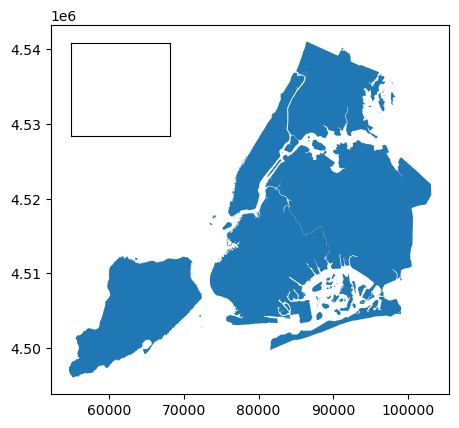

In [3]:
ax = nybb.plot()

# Now adding an inset axis
iax = ax.inset_axes([0.05, 0.70, 0.25, 0.25], xticks=[], yticks=[])
# Additional data may now be plotted on this axis
# ex. new_york_state.plot(ax=iax)

### Using `mpl_toolkits.axes_grid1.inset_locator.inset_axes`

Another option is available in the `mpl_toolkits` part of matplotlib, via the function [inset_axes](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.inset_axes.html).

This separate `inset_axes()` function provided by `matplotlib` is intended to be used in a similar way to the `inset_axes()` method of the Axes class. However, it may also (optionally) be paired with `mark_inset()` ([documentation](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.mark_inset.html)) to connect the inset axes to the parent axes, in the case where the inset axes are showing additional detail of a small area of the parent axes.

In [4]:
from mpl_toolkits.axes_grid1 import inset_locator

#### Creating a Parent and Inset Axis
At a high level, creating a simple parent and inset axis occurs with more-or-less the same workflow as above.

However, this `inset_axes()` function is very different from the `inset_axes()` method of the Axes class; most notably: 

- It is applied as a standalone function (via `mpl_toolkits.axes_grid1.inset_locator.inset_axes()`) rather than as a method of an Axes object (like `ax.inset_axes()`). As such, the parent axes must be passed as the first argument.

- Instead of providing a 4-tuple of values specifying the bottom-left corner and width and height of the inset axes, it requires separate values for `width` and `height`, as well as a `loc` keyword similar to how `Legend` objects are placed. 

  - If integers or floats are passed to width and height, they are interpreted as *inches*. If strings are passed, they are interpreted as percentages of the parent axes, or to the bounding box specified under `bbox_to_anchor`.

  - The `loc` keyword is similar to the `loc` keyword of `Legend` objects. It can be a string or an integer. See [the documentation](https://matplotlib.org/stable/api/legend_api.html#matplotlib.legend.Legend) for more details.

  - Advanced positioning is also possible via `bbox_to_anchor`, and `bbox_transform`, just like `Legend`s. See [the documentation](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.inset_axes.html) for more details.

- While kwargs are accepted and passed along when creating the inset axes, they must be provided in for the form of a dictionary via the `axes_kwargs` keyword.

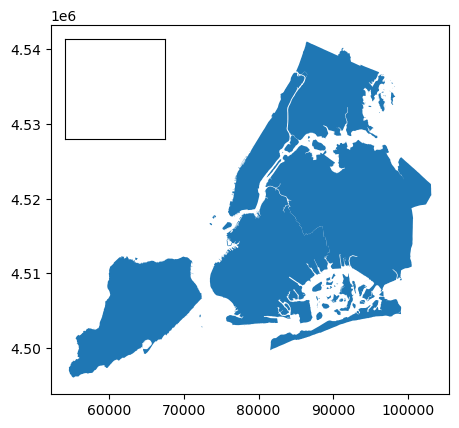

In [5]:
ax = nybb.plot()

# Now adding an inset axis
iax = inset_locator.inset_axes(ax, width=1, height=1, loc="upper left", borderpad=1, axes_kwargs={"xticks":[], "yticks":[]})

#### Marking an Indicator
Unique to the `mpl_toolkits.axes_grid1` approach, the `mark_inset()` function can be used to connect the inset axes to the parent axes, in the case that the inset axes is displaying a zoomed-in section of the parent axes. See [this documentation](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.inset_locator.mark_inset.html) for more details.

**Important:** For this function to work, both the inset and parent axes **must** be using the same coordinate system.

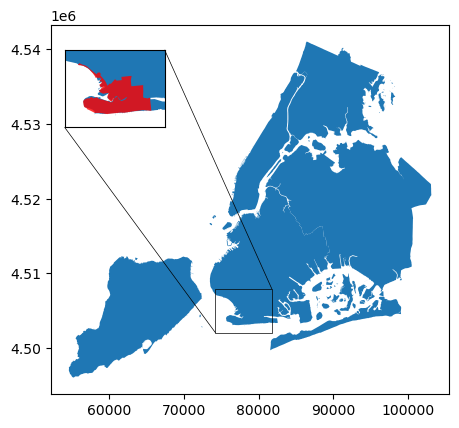

In [6]:
ax = nybb.plot()

# Now adding an inset axis
iax = inset_locator.inset_axes(ax, width=1, height=1, loc="upper left", borderpad=1, axes_kwargs={"xticks":[], "yticks":[]})
# Zooming into the neighborhood of Coney Island
nyc = gpd.read_file(get_path('geoda.nyc')).to_crs(epsg=32619)
coney = nyc.query("name=='Coney Island'")
minx, miny, maxx, maxy = coney.buffer(1000).total_bounds
nybb.plot(ax=iax)
coney.plot(ax=iax, color="red", alpha=0.8)
iax.set_xlim(minx, maxx)
iax.set_ylim(miny, maxy)


# Connecting the inset axis to the main axis
# Note: loc1 and loc2 will accept the integers 1, 2, 3, or 4, each corresponding to a different corner
# 1 = upper right, 2 = upper left, 3 = lower left, 4 = lower right
_ = inset_locator.mark_inset(ax, iax, loc1=1, loc2=3, linewidth=0.5)

## Using `matplotlib-map-utils`

Other option is the [matplotlib-map-utils]((https://github.com/moss-xyz/matplotlib-map-utils)) library.

This library is intended to provide an easier-to-use interface for constructing inset maps (along with scale bars and north arrows) for matplotlib plots than either the `inset_axes()` method or function.

Using this package, an inset map and its relevant indicators can be made with either **functions** or **classes**, which are re-usable across plots; for the purposes of this tutorial, only the *functions* will be used, though the *classes* work in much the same way. Tutorials for customizing the map are available within the `docs` directory of the repository (see [here](https://github.com/moss-xyz/matplotlib-map-utils/blob/main/matplotlib_map_utils/docs/howto_inset_map.ipynb)).

In [7]:
from matplotlib_map_utils.core.inset_map import inset_map, indicate_extent, indicate_detail
from matplotlib_map_utils import set_size


### Set-Up

If you are working with a common plot size, `matplotlib-map-utils` has a function called `set_size()` that bulk-updates a variety of settings so that the relevant object looks "better" at that size.

GeoPandas' `plot()` function will create figures of `6.4"x4.8"` with the data used in this tutorial, which corresponds to a size of `small`.

In [8]:
set_size("small")

### Creating an inset map

The `inset_map()` function takes in the following arguments:

* `ax`: the axis on which to plot the inset map

* `location`: a string indicating the location of the inset map on the plot (see `loc` under `matplotlib.pyplot.legend` ([documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)) e.g., "upper left", "lower right", etc.)

* `scale`: the desired height of the north arrow, in *inches*; can be a single value for a square map, or a two-tuple of (width, height)

* `pad`: the amount of padding between the inset map and the edge of the plot, in *inches*

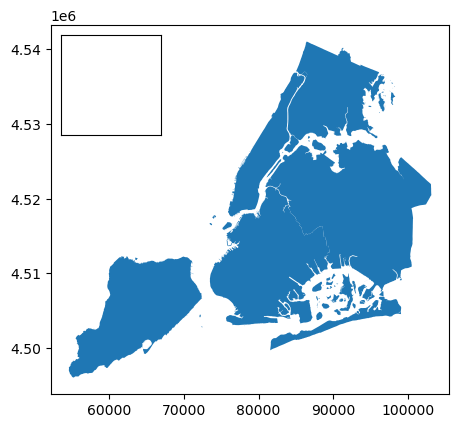

In [9]:
# Making a basic arrow using the minimum amount of arguments
ax = nybb.plot()
# This is using the default values for `scale` and `pad`
# xticks and yticks are kwargs passed along to the axis constructor
iax = inset_map(ax, location="upper left", xticks=[], yticks=[])
# iax can now be plotted on like normal

Optional additional arguments can be passed, such as `coords` and `transform` for positioning the map, `to_plot` for plotting additional data, and any `kwarg` accepted as by an Axes object; see the documentation under `docs\howto_inset_map.ipynb` in [the GitHub repo](https://github.com/moss-xyz/matplotlib-map-utils/blob/main/matplotlib_map_utils/docs/howto_inset_map.ipynb) for details.

### Creating indicators

`matplotlib-map-utils` makes two indicators available:

- *Extent indicators* may be used when the inset map shows a *zoomed-out* version of the parent axes, providing additional location context; in this instance, the extent indicator will show the boundary of the extent of the parent axes on the inset map.

- *Detail indicators* may be used in the opposite scenario, when the inset map shows a *zoomed-in* version of the parent axes; in this instance, the detail indicator will show the boundary of the extent of the inset map on the parent axes, and connect the two together, just as `mark_inset())` does, above.

To work, both indicators require the CRSs of both the parent and inset axes; however, they do not require the CRSs be the same, and will handle conversion between the two.

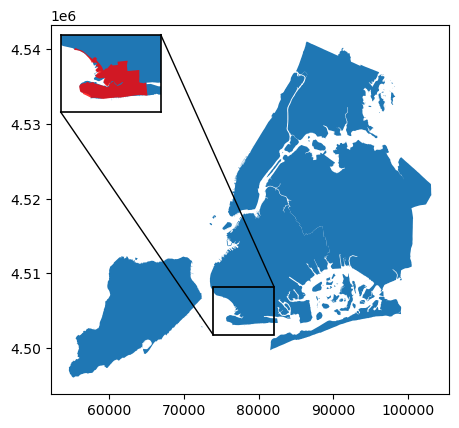

In [10]:
# Detail indicator example
ax = nybb.plot()

# Now adding an inset axis
iax = inset_map(ax, location="upper left", xticks=[], yticks=[])
# Zooming into the neighborhood of Coney Island
coney = nyc.query("name=='Coney Island'")
minx, miny, maxx, maxy = coney.buffer(1000).total_bounds
nybb.plot(ax=iax)
coney.plot(ax=iax, color="red", alpha=0.8)
iax.set_xlim(minx, maxx)
iax.set_ylim(miny, maxy)

# Connecting the inset axis to the main axis
indicate_detail(pax=ax, iax=iax, pcrs=32619, icrs=32619)

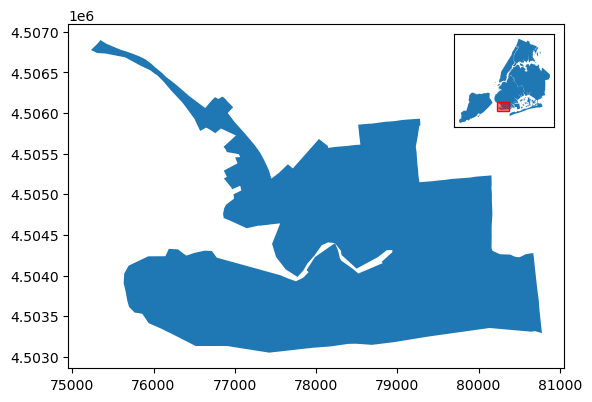

In [11]:
# Extent indicator example
# Note that we reverse which data is plotted on which axis!
# Parent axis will have the neighborhood
ax = nyc.query("name=='Coney Island'").plot()

# Now adding an inset axis
iax = inset_map(ax, location="upper right", xticks=[], yticks=[])

# Inset axis will have the whole city
nybb.plot(ax=iax)

# Connecting the inset axis to the main axis
# The indicator is the red box that appears in the inset axis
indicate_extent(pax=iax, bax=ax, pcrs=32619, bcrs=32619)